In [ ]:
!pip install opencv-python-headless


Saving chessboard.png to chessboard (1).png
1 image(s) uploaded.

Processing Image: chessboard (1).png
Detected a 8x8 chessboard
Method 1 (Corner Detection):
  Chessboard Size: 8x8
  White Squares: 30
  Black Squares: 34
  Total Squares: 64


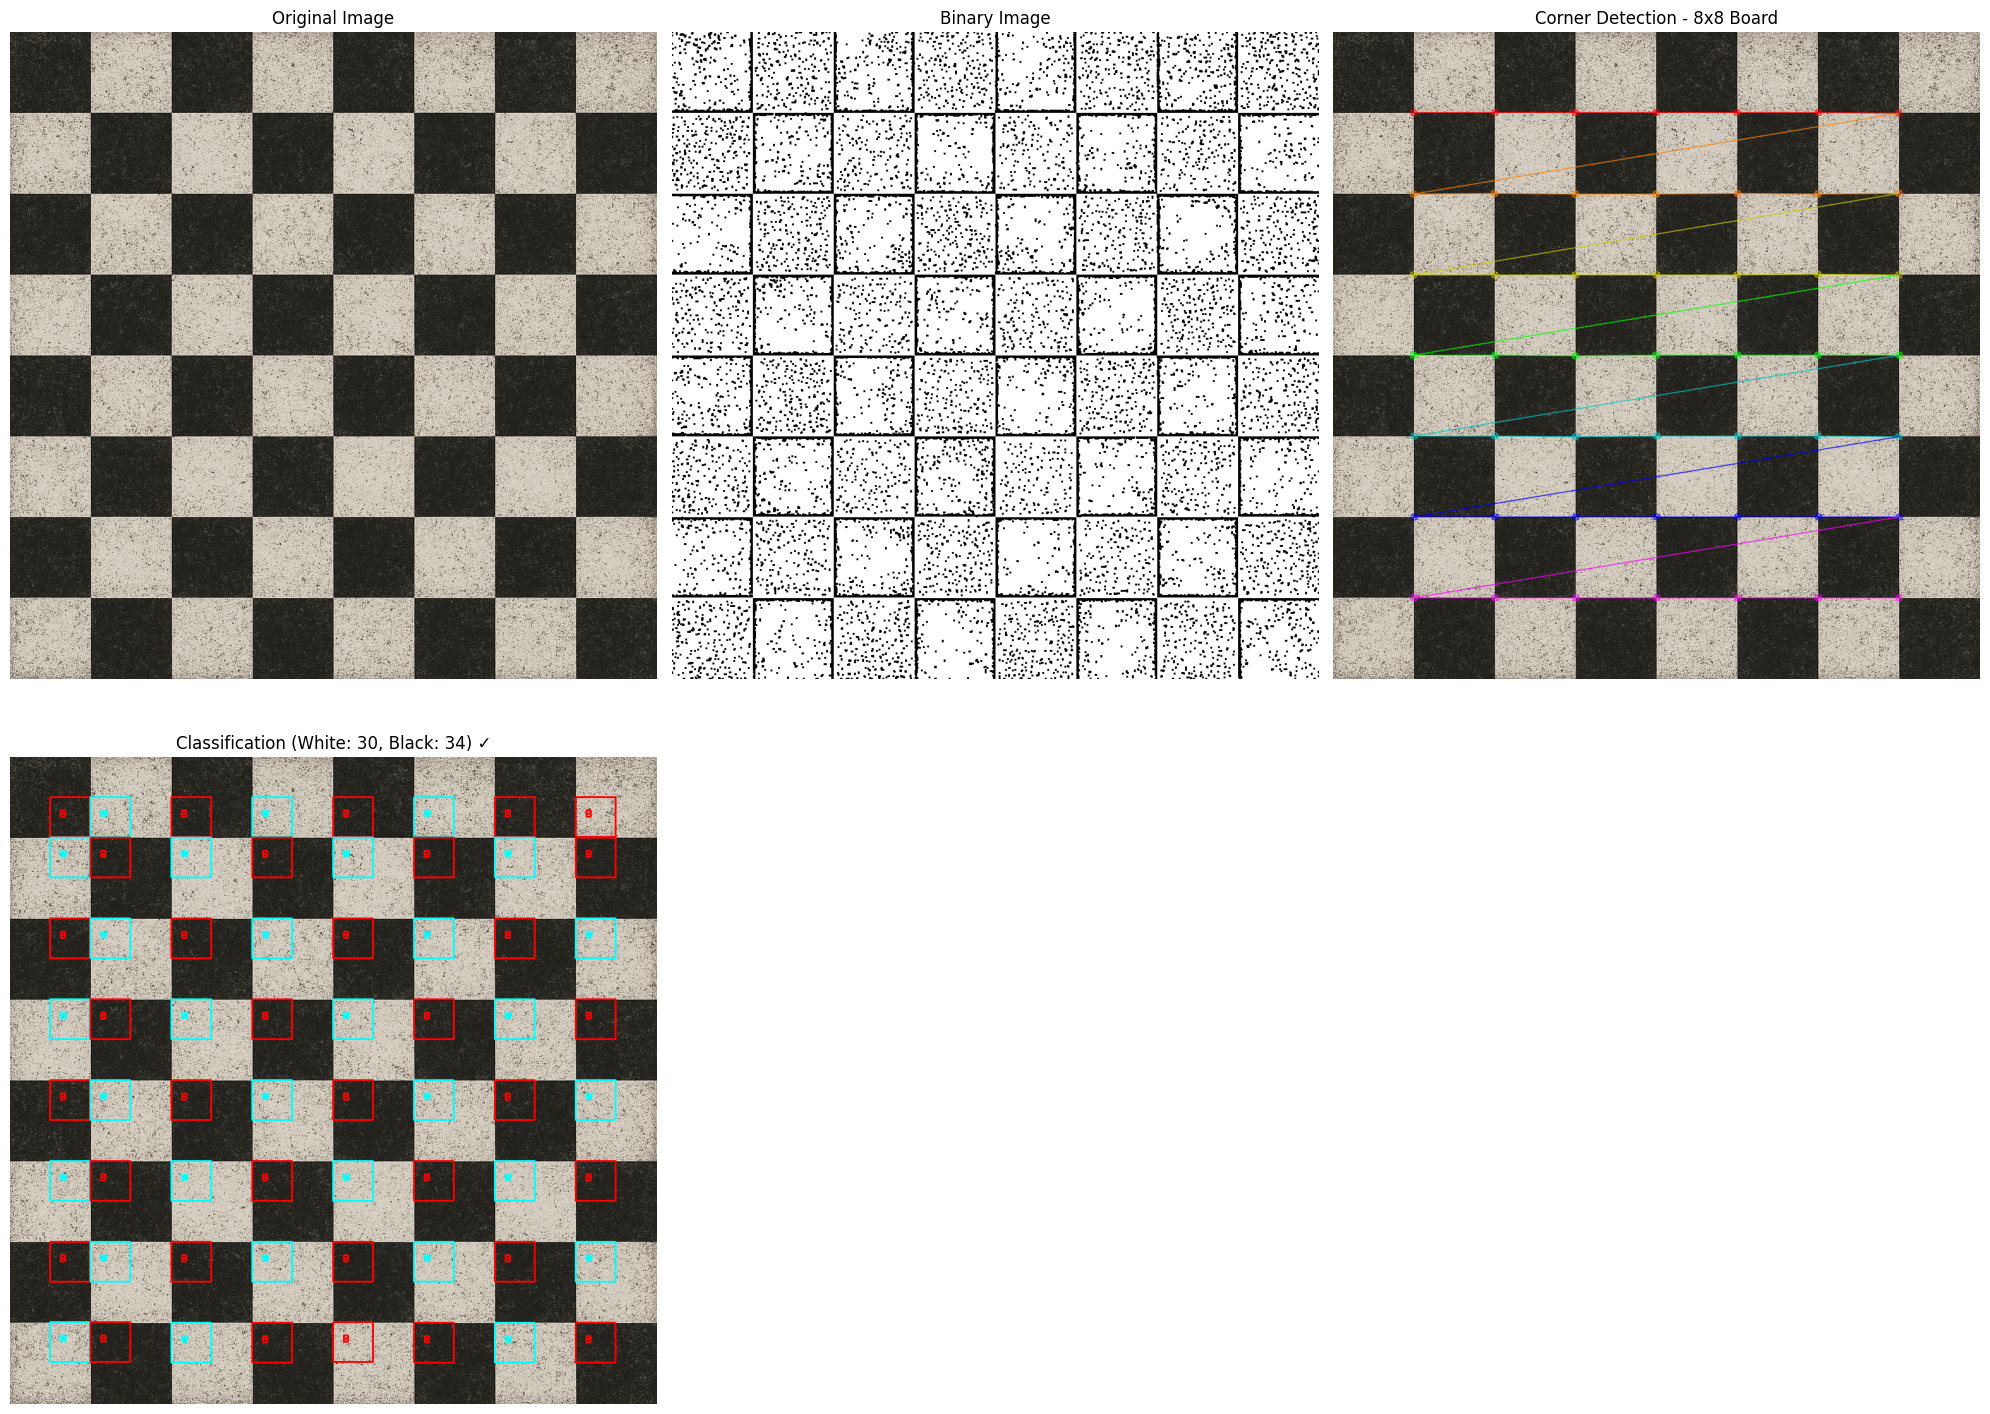

In [56]:
# Step 1: Install & Import Required Libraries
# Install required packages
import sys
import subprocess
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'opencv-python-headless'])

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from PIL import Image
import io

# Step 2: Upload Chessboard Images
# Upload the chessboard images you want to process
uploaded = files.upload()

# Load uploaded images into a list
image_list = []
for filename in uploaded.keys():
    img = Image.open(io.BytesIO(uploaded[filename]))
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image_list.append((img, filename))

print(f"{len(image_list)} image(s) uploaded.")

# Step 3: Improved Preprocessing
def preprocess_image(img):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding - more robust to lighting variations
    binary = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Apply morphological operations to reduce noise
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    return gray, binary

# Step 4: Detect Chessboard and Correct Perspective
def detect_chessboard(img, binary):
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    chessboard_contour = None
    for contour in contours[:5]:  # Check the 5 largest contours
        # Approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

        # If the approximated contour has 4 points, it's likely our chessboard
        if len(approx) == 4:
            chessboard_contour = approx
            break

    if chessboard_contour is None:
        return None, img, None, None

    # Draw the detected chessboard contour
    detected_image = img.copy()
    cv2.drawContours(detected_image, [chessboard_contour], -1, (0, 255, 0), 3)

    # Apply perspective correction
    # Reorder points for correct perspective transformation
    points = chessboard_contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    # Top-left point has the smallest sum
    # Top-right point has the smallest difference
    # Bottom-right point has the largest sum
    # Bottom-left point has the largest difference
    s = points.sum(axis=1)
    rect[0] = points[np.argmin(s)]
    rect[2] = points[np.argmax(s)]

    diff = np.diff(points, axis=1)
    rect[1] = points[np.argmin(diff)]
    rect[3] = points[np.argmax(diff)]

    # Calculate the width and height of the chessboard
    width_a = np.sqrt(((rect[2][0] - rect[3][0]) ** 2) + ((rect[2][1] - rect[3][1]) ** 2))
    width_b = np.sqrt(((rect[1][0] - rect[0][0]) ** 2) + ((rect[1][1] - rect[0][1]) ** 2))
    width = max(int(width_a), int(width_b))

    height_a = np.sqrt(((rect[1][0] - rect[2][0]) ** 2) + ((rect[1][1] - rect[2][1]) ** 2))
    height_b = np.sqrt(((rect[0][0] - rect[3][0]) ** 2) + ((rect[0][1] - rect[3][1]) ** 2))
    height = max(int(height_a), int(height_b))

    # Set up the destination points for the perspective transformation
    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    # Calculate the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (width, height))

    # Calculate perspective transform for binary image as well
    binary_warped = cv2.warpPerspective(binary, M, (width, height))

    return chessboard_contour, detected_image, warped, binary_warped

# Step 5: Detect Grid Size using Hough Lines
def detect_grid_size(binary_img):
    # Apply Canny edge detection
    edges = cv2.Canny(binary_img, 50, 150, apertureSize=3)

    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=100)

    if lines is None:
        return None, None, edges

    # Separate horizontal and vertical lines
    horizontal_lines = []
    vertical_lines = []

    for line in lines:
        rho, theta = line[0]
        # Filter lines by angle
        if abs(theta) < 0.1 or abs(theta - np.pi) < 0.1:  # Vertical lines
            vertical_lines.append(line)
        elif abs(theta - np.pi/2) < 0.1:  # Horizontal lines
            horizontal_lines.append(line)

    # Function to draw lines for visualization
    def draw_lines(img, lines, color=(0, 255, 0)):
        result = img.copy()
        if len(img.shape) == 2:
            result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(result, (x1, y1), (x2, y2), color, 2)
        return result

    # Draw detected lines
    lines_img = draw_lines(binary_img, lines)

    # Cluster lines to find grid
    def cluster_lines(lines, img_size):
        positions = []
        for line in lines:
            rho, theta = line[0]
            if abs(theta - np.pi/2) < 0.1:  # Horizontal
                positions.append(abs(rho))
            else:  # Vertical
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a * rho
                positions.append(abs(x0))

        positions = sorted(positions)

        # Calculate distances between consecutive lines
        distances = []
        for i in range(1, len(positions)):
            dist = positions[i] - positions[i-1]
            if dist > 5:  # Minimum distance to avoid duplicates
                distances.append(dist)

        if not distances:
            return 0

        # Estimate square size based on median distance
        median_dist = np.median(distances)

        # Count the number of cells
        range_total = positions[-1] - positions[0]
        estimated_cells = round(range_total / median_dist) + 1

        return estimated_cells

    # Count cells in both directions
    h_size = cluster_lines(horizontal_lines, binary_img.shape[0])
    v_size = cluster_lines(vertical_lines, binary_img.shape[1])

    # For standard chessboards, if we detect 7 lines, it's an 8x8 board
    # If we detect 9 lines, it's a 10x10 board, etc.
    grid_rows = h_size + 1 if h_size > 0 else 0
    grid_cols = v_size + 1 if v_size > 0 else 0

    # If the detection is approximate or incomplete, make an estimate
    if grid_rows < 5 or grid_cols < 5:
        # Look for standard sizes, most chessboards are 8x8
        std_sizes = [8, 10, 6]
        for size in std_sizes:
            # Check if the image proportions match this size
            aspect_ratio = binary_img.shape[1] / binary_img.shape[0]
            if 0.8 <= aspect_ratio <= 1.2:  # If square-ish
                return size, size, lines_img

    # Check if grid size seems reasonable
    if 5 <= grid_rows <= 12 and 5 <= grid_cols <= 12:
        return grid_rows, grid_cols, lines_img

    # Default to standard 8x8 if detection failed
    return 8, 8, lines_img

# Step 6: Detect Squares Using Grid-based Approach
def detect_squares_grid(warped, binary_warped, rows=8, cols=8):
    height, width = binary_warped.shape

    # Use detected grid size
    square_width = width // cols
    square_height = height // rows

    # Create squares based on grid
    squares = []
    for r in range(rows):
        for c in range(cols):
            x = c * square_width
            y = r * square_height
            squares.append((x, y, square_width, square_height))

    # Draw squares on the image
    result_image = warped.copy()
    for x, y, w, h in squares:
        cv2.rectangle(result_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

    return squares, result_image

# Step 7: Alternative Method for Corner Detection
def detect_with_corners(gray_img, img):
    # Try different board sizes (from 7x7 to 3x3 internal corners)
    board_sizes = [(7, 7), (6, 6), (5, 5), (4, 4), (9, 9), (8, 8)]
    corners_found = False
    result_image = img.copy()
    squares = []
    detected_size = None

    for board_size in board_sizes:
        # findChessboardCorners looks for internal corners
        # A standard 8x8 chessboard has 7x7 internal corners
        ret, corners = cv2.findChessboardCorners(gray_img, board_size, None)

        if ret:
            corners_found = True
            rows, cols = board_size
            detected_size = (rows + 1, cols + 1)  # Convert internal corners to grid size
            print(f"Detected a {detected_size[0]}x{detected_size[1]} chessboard")

            # Draw the corners
            cv2.drawChessboardCorners(result_image, board_size, corners, ret)

            # Create squares from corners
            # This is an approximation as we only have internal corners
            corner_points = corners.reshape(-1, 2)

            # Estimate square size based on distance between corners
            avg_dist_x = 0
            avg_dist_y = 0
            count = 0

            for i in range(1, len(corner_points)):
                if i % cols != 0:  # Not the last in row
                    avg_dist_x += corner_points[i][0] - corner_points[i-1][0]
                    count += 1

            for i in range(cols, len(corner_points)):
                avg_dist_y += corner_points[i][1] - corner_points[i-cols][1]
                count += 1

            avg_dist_x /= max(1, count)
            avg_dist_y /= max(1, count)

            # Create squares using estimated distances
            # We have (r+1) x (c+1) squares for r x c internal corners
            for r in range(rows + 1):
                for c in range(cols + 1):
                    # Estimate corner positions, including outside corners
                    x = corner_points[0][0] - avg_dist_x
                    y = corner_points[0][1] - avg_dist_y

                    if r > 0 and c > 0 and (r-1)*cols + (c-1) < len(corner_points):
                        x = corner_points[(r-1)*cols + (c-1)][0]
                        y = corner_points[(r-1)*cols + (c-1)][1]
                    elif r > 0 and (r-1)*cols < len(corner_points):
                        x = corner_points[(r-1)*cols][0] - avg_dist_x
                        y = corner_points[(r-1)*cols][1]
                    elif c > 0 and c-1 < len(corner_points):
                        x = corner_points[c-1][0]
                        y = corner_points[c-1][1] - avg_dist_y

                    squares.append((int(x), int(y), int(avg_dist_x), int(avg_dist_y)))

            break

    if not corners_found:
        return False, [], result_image, None

    return True, squares, result_image, detected_size

# Function to verify expected square counts
def verify_board_counts(rows, cols, white_count, black_count):
    """Verify that the counts of white and black squares make sense for the given board size."""
    total_squares = rows * cols
    expected_counts = {}

    # For an 8x8 standard chess board, we expect 32 white and 32 black
    if rows == 8 and cols == 8:
        expected_counts = {"white": 32, "black": 32}
    # For a 7x7 board, we expect 25 of one color and 24 of the other
    elif rows == 7 and cols == 7:
        expected_counts = {"white": 25, "black": 24}
        # The first square could be either black or white
        # If white_count is significantly less than black_count, swap them
        if white_count < black_count - 5:
            expected_counts = {"white": 24, "black": 25}
    # For a 6x6 board, we expect 18 of each color
    elif rows == 6 and cols == 6:
        expected_counts = {"white": 18, "black": 18}
    # For other sizes, calculate based on even/odd dimensions
    else:
        if (rows * cols) % 2 == 0:
            # Even total - equal distribution
            expected_counts = {"white": total_squares // 2, "black": total_squares // 2}
        else:
            # Odd total - one more of starting color
            if (rows % 2 == 1 and cols % 2 == 1):
                expected_counts = {"white": (total_squares // 2) + 1, "black": total_squares // 2}
            else:
                expected_counts = {"white": total_squares // 2, "black": (total_squares // 2) + 1}

    return {
        "expected": expected_counts,
        "actual": {"white": white_count, "black": black_count},
        "total_expected": total_squares,
        "total_actual": white_count + black_count,
        "is_valid": abs(white_count - expected_counts["white"]) <= 3 and abs(black_count - expected_counts["black"]) <= 3
    }

# Step 8: Classify Squares into Black or White
def classify_squares(img, squares, rows=8, cols=8):
    white_squares = []
    black_squares = []
    result_image = img.copy()

    # Determine starting color (top-left is white in standard chess)
    start_with_white = True

    # Total expected squares
    total_squares = len(squares)

    # For tracking the classification
    square_count = 0

    # If we have a reasonable number of squares detected
    if 0.7 * rows * cols <= total_squares <= 1.3 * rows * cols:
        # Calculate the grid arrangement (this is approximate)
        grid_rows = int(np.sqrt(total_squares))
        grid_cols = total_squares // grid_rows

        # Create a 2D grid to help with pattern recognition
        grid = np.zeros((grid_rows, grid_cols), dtype=int)

        # Arrange squares in a grid by position
        square_positions = []
        for x, y, w, h in squares:
            center_x = x + w // 2
            center_y = y + h // 2
            square_positions.append((center_x, center_y, x, y, w, h))

        # Sort squares by y position first (rows)
        square_positions.sort(key=lambda p: p[1])

        # Group squares into rows
        row_groups = []
        current_row = []
        prev_y = square_positions[0][1]

        for pos in square_positions:
            if abs(pos[1] - prev_y) > pos[4] // 2 and current_row:  # If significant y change and row not empty
                row_groups.append(current_row)
                current_row = [pos]
                prev_y = pos[1]
            else:
                current_row.append(pos)
                prev_y = (prev_y + pos[1]) // 2  # Update average y

        if current_row:
            row_groups.append(current_row)

        # Sort each row by x position
        for i in range(len(row_groups)):
            row_groups[i].sort(key=lambda p: p[0])

        # Construct the 2D grid
        for r, row in enumerate(row_groups):
            for c, (_, _, x, y, w, h) in enumerate(row):
                # Get square ROI
                square_roi = img[y:y+h, x:x+w]

                # Convert to grayscale if not already
                if len(square_roi.shape) == 3:
                    square_roi = cv2.cvtColor(square_roi, cv2.COLOR_BGR2GRAY)

                # Calculate average pixel value
                avg_value = np.mean(square_roi)

                # For chess pattern, color alternates
                expected_white = (r + c) % 2 == 0 if start_with_white else (r + c) % 2 != 0

                # Brightness-based classification
                is_white_by_brightness = avg_value > 110

                # Decide classification
                # Use pattern for most squares, but for very clear black/white, use brightness
                if abs(avg_value - 127) > 60:  # Very clearly black or white
                    is_white = is_white_by_brightness
                else:  # Follow the pattern
                    is_white = expected_white

                # Record in our grid
                grid[r][c] = 1 if is_white else 0

                # Assign color
                if is_white:
                    color = (255, 255, 0)  # Yellow outline for white squares
                    white_squares.append((x, y, w, h))
                else:
                    color = (0, 0, 255)  # Red outline for black squares
                    black_squares.append((x, y, w, h))

                # Draw rectangle and color label on result image
                cv2.rectangle(result_image, (x, y), (x+w, y+h), color, 2)

                # Add color label text
                label = "W" if is_white else "B"
                cv2.putText(result_image, label, (x+w//4, y+h//2),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    else:
        # Fallback to simpler classification if grid arrangement failed
        for x, y, w, h in squares:
            # Ensure we're within image boundaries
            if x < 0 or y < 0 or x+w >= img.shape[1] or y+h >= img.shape[0]:
                continue

            # Get square ROI
            square_roi = img[y:y+h, x:x+w]

            # Convert to grayscale if not already
            if len(square_roi.shape) == 3:
                square_roi = cv2.cvtColor(square_roi, cv2.COLOR_BGR2GRAY)

            # Calculate average pixel value
            avg_value = np.mean(square_roi)

            # Get row and column for chess pattern
            row = square_count // int(np.sqrt(len(squares)))
            col = square_count % int(np.sqrt(len(squares)))

            # For chess pattern, color alternates
            expected_white = (row + col) % 2 == 0 if start_with_white else (row + col) % 2 != 0

            # Classify based on average brightness with pattern guidance
            if avg_value > 110:  # Adjust threshold if needed
                color = (255, 255, 0)  # Yellow outline for white squares
                white_squares.append((x, y, w, h))
            else:
                color = (0, 0, 255)  # Red outline for black squares
                black_squares.append((x, y, w, h))

            # Draw rectangle and color label on result image
            cv2.rectangle(result_image, (x, y), (x+w, y+h), color, 2)

            # Add color label text
            label = "W" if avg_value > 110 else "B"
            cv2.putText(result_image, label, (x+w//4, y+h//2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            square_count += 1

    # Verify that the counts make sense for this grid size
    verification = verify_board_counts(rows, cols, len(white_squares), len(black_squares))

    # Return the squared results and verification
    return white_squares, black_squares, result_image

# Step 9: Run Full Pipeline on Uploaded Images
for idx, (img, filename) in enumerate(image_list):
    print(f"\nProcessing Image: {filename}")

    # Create a figure for displaying results
    plt.figure(figsize=(20, 15))

    # Display original image
    plt.subplot(2, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Preprocess the image
    gray, binary = preprocess_image(img)

    # Display binary image
    plt.subplot(2, 3, 2)
    plt.title("Binary Image")
    plt.imshow(binary, cmap='gray')
    plt.axis('off')

    # Try the corner detection method first (most reliable)
    corners_found, corner_squares, corner_result, corner_size = detect_with_corners(gray, img)

    if corners_found:
        # Method 1: OpenCV's findChessboardCorners
        white_squares, black_squares, classified_img = classify_squares(img, corner_squares, corner_size[0], corner_size[1])

        # Verify that the counts make sense for this grid size
        verification = verify_board_counts(corner_size[0], corner_size[1], len(white_squares), len(black_squares))

        # Display corner detection result
        plt.subplot(2, 3, 3)
        plt.title(f"Corner Detection - {corner_size[0]}x{corner_size[1]} Board")
        plt.imshow(cv2.cvtColor(corner_result, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Display classification result
        plt.subplot(2, 3, 4)
        if verification["is_valid"]:
            plt.title(f"Classification (White: {len(white_squares)}, Black: {len(black_squares)}) ✓")
        else:
            plt.title(f"Classification (White: {len(white_squares)}, Black: {len(black_squares)}) ✗\nExpected: W:{verification['expected']['white']}, B:{verification['expected']['black']}")
        plt.imshow(cv2.cvtColor(classified_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        print(f"Method 1 (Corner Detection):")
        print(f"  Chessboard Size: {corner_size[0]}x{corner_size[1]}")
        print(f"  White Squares: {len(white_squares)}")
        print(f"  Black Squares: {len(black_squares)}")
        print(f"  Total Squares: {len(white_squares) + len(black_squares)}")
        if not verification["is_valid"]:
            print(f"  Note: Square counts don't match expected values for a {corner_size[0]}x{corner_size[1]} board.")
            print(f"  Expected: White: {verification['expected']['white']}, Black: {verification['expected']['black']}")
    else:
        # Method 2: Contour detection and perspective correction
        try:
            chessboard_contour, detected_image, warped, binary_warped = detect_chessboard(img, binary)

            if chessboard_contour is not None and warped is not None:
                # Display detected chessboard
                plt.subplot(2, 3, 3)
                plt.title("Detected Chessboard")
                plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
                plt.axis('off')

                # Display perspective corrected image
                plt.subplot(2, 3, 4)
                plt.title("Perspective Corrected")
                plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
                plt.axis('off')

                # Detect grid size
                grid_rows, grid_cols, grid_lines = detect_grid_size(binary_warped)

                # Display grid lines
                plt.subplot(2, 3, 5)
                plt.title(f"Grid Detection: {grid_rows}x{grid_cols}")
                plt.imshow(grid_lines)
                plt.axis('off')

                # Detect squares using grid-based approach
                squares, result_image = detect_squares_grid(warped, binary_warped, grid_rows, grid_cols)

                # Classify squares
                white_squares, black_squares, classified_img = classify_squares(warped, squares, grid_rows, grid_cols)

                # Verify that the counts make sense for this grid size
                verification = verify_board_counts(grid_rows, grid_cols, len(white_squares), len(black_squares))

                # Display classification result
                plt.subplot(2, 3, 6)
                if verification["is_valid"]:
                    plt.title(f"Classification (White: {len(white_squares)}, Black: {len(black_squares)}) ✓")
                else:
                    plt.title(f"Classification (White: {len(white_squares)}, Black: {len(black_squares)}) ✗\nExpected: W:{verification['expected']['white']}, B:{verification['expected']['black']}")
                plt.imshow(cv2.cvtColor(classified_img, cv2.COLOR_BGR2RGB))
                plt.axis('off')

                print(f"Method 2 (Contour + Grid Detection):")
                print(f"  Detected Chessboard Size: {grid_rows}x{grid_cols}")
                print(f"  White Squares: {len(white_squares)}")
                print(f"  Black Squares: {len(black_squares)}")
                print(f"  Total Squares: {len(white_squares) + len(black_squares)}")
                if not verification["is_valid"]:
                    print(f"  Note: Square counts don't match expected values for a {grid_rows}x{grid_cols} board.")
                    print(f"  Expected: White: {verification['expected']['white']}, Black: {verification['expected']['black']}")
            else:
                print("Failed to detect chessboard using contour method.")
                plt.subplot(2, 3, 3)
                plt.title("Chessboard Detection Failed")
                plt.axis('off')
        except Exception as e:
            print(f"Error in contour detection: {str(e)}")

    plt.tight_layout()
    plt.show()